In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import shap

shap.initjs()  # Needed to render SHAP plots in Jupyter

df = pd.read_csv('../data/processed/user_experiment_data_clean.csv')

# Feature Engineering — create new signals from existing columns
df['engagement_drop'] = df['pre_daily_active_minutes'] - df['daily_active_minutes']  # Did usage drop?
df['is_new_user'] = (df['account_age_months'] < 6).astype(int)
df['recency_score'] = 1 / (df['days_since_last_login'] + 1)  # Higher = logged in more recently
df['follower_following_ratio'] = df['follower_count'] / (df['following_count'] + 1)

print("New features added:", ['engagement_drop', 'is_new_user', 'recency_score', 'follower_following_ratio'])

New features added: ['engagement_drop', 'is_new_user', 'recency_score', 'follower_following_ratio']


In [2]:
# Select features to feed into the model
feature_cols = [
    'daily_active_minutes', 'interaction_rate', 'stories_watched',
    'scroll_depth', 'days_since_last_login', 'account_age_months',
    'following_count', 'follower_count', 'pre_daily_active_minutes',
    'pre_interaction_rate', 'engagement_drop', 'is_new_user',
    'recency_score', 'follower_following_ratio'
]

# Encode categorical columns (ML models need numbers, not strings)
le_group = LabelEncoder()
le_age = LabelEncoder()
le_acct = LabelEncoder()

df['group_encoded'] = le_group.fit_transform(df['group'])          # control=0, treatment=1
df['age_encoded'] = le_age.fit_transform(df['age_group'])
df['acct_encoded'] = le_acct.fit_transform(df['account_type'])

feature_cols += ['group_encoded', 'age_encoded', 'acct_encoded']

X = df[feature_cols]
y = df['churned_30d']

print(f"Features shape: {X.shape}")
print(f"Churn rate: {y.mean():.1%}")
print(f"Class balance - Churned: {y.sum():,} | Not Churned: {(y==0).sum():,}")

Features shape: (50000, 17)
Churn rate: 12.6%
Class balance - Churned: 6,280 | Not Churned: 43,720


In [3]:
# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # stratify keeps churn rate same in both splits
)

print(f"Training set: {X_train.shape[0]:,} rows")
print(f"Test set: {X_test.shape[0]:,} rows")

# Handle class imbalance with SMOTE (creates synthetic examples of the minority class)
# Why? ~12% churn means our model might just predict "not churn" for everyone and be 88% accurate — useless
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"\nAfter SMOTE:")
print(f"Churned: {y_train_balanced.sum():,} | Not Churned: {(y_train_balanced==0).sum():,}")

Training set: 40,000 rows
Test set: 10,000 rows

After SMOTE:
Churned: 34,976 | Not Churned: 34,976


In [4]:
model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    early_stopping_rounds=20
)

model.fit(
    X_train_balanced, y_train_balanced,
    eval_set=[(X_test, y_test)],
    verbose=50  # Print progress every 50 trees
)

# Evaluate
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"\n{'='*40}")
print(f"AUC-ROC Score: {auc:.4f}")
print(f"{'='*40}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Churned', 'Churned']))

[0]	validation_0-logloss:0.64440
[50]	validation_0-logloss:0.04103
[100]	validation_0-logloss:0.00365
[150]	validation_0-logloss:0.00036
[200]	validation_0-logloss:0.00006
[250]	validation_0-logloss:0.00004
[251]	validation_0-logloss:0.00004

AUC-ROC Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

 Not Churned       1.00      1.00      1.00      8744
     Churned       1.00      1.00      1.00      1256

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



[19:31:57] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


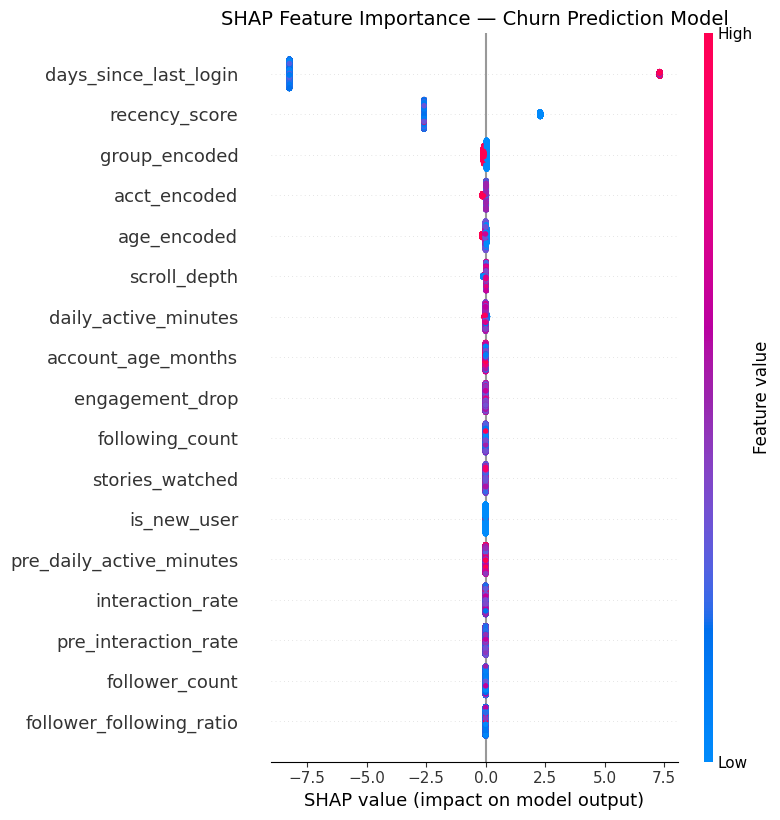

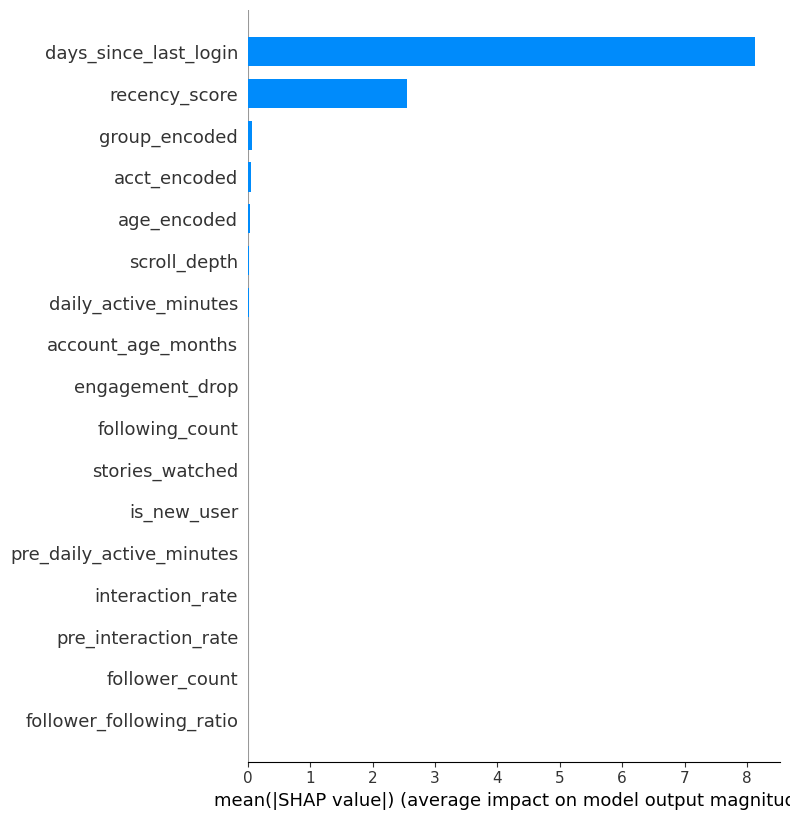

In [5]:
# Calculate SHAP values
explainer = shap.Explainer(model, X_train_balanced)
shap_values = explainer(X_test)

# Summary plot — which features matter most overall?
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, feature_names=feature_cols, show=False)
plt.title("SHAP Feature Importance — Churn Prediction Model", fontsize=14)
plt.tight_layout()
plt.savefig('../reports/shap_summary.png', dpi=150, bbox_inches='tight')
plt.show()

# Bar plot version (easier to explain in presentations)
shap.summary_plot(shap_values, X_test, feature_names=feature_cols, plot_type='bar', show=False)
plt.savefig('../reports/shap_importance_bar.png', dpi=150, bbox_inches='tight')
plt.show()

In [6]:
import pickle

# Save model
with open('../src/churn_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Save predictions back to dataframe
df_test = X_test.copy()
df_test['actual_churn'] = y_test.values
df_test['churn_probability'] = y_pred_proba
df_test['predicted_churn'] = y_pred
df_test.to_csv('../data/processed/churn_predictions.csv', index=False)

print("✅ Model saved and predictions exported")

✅ Model saved and predictions exported


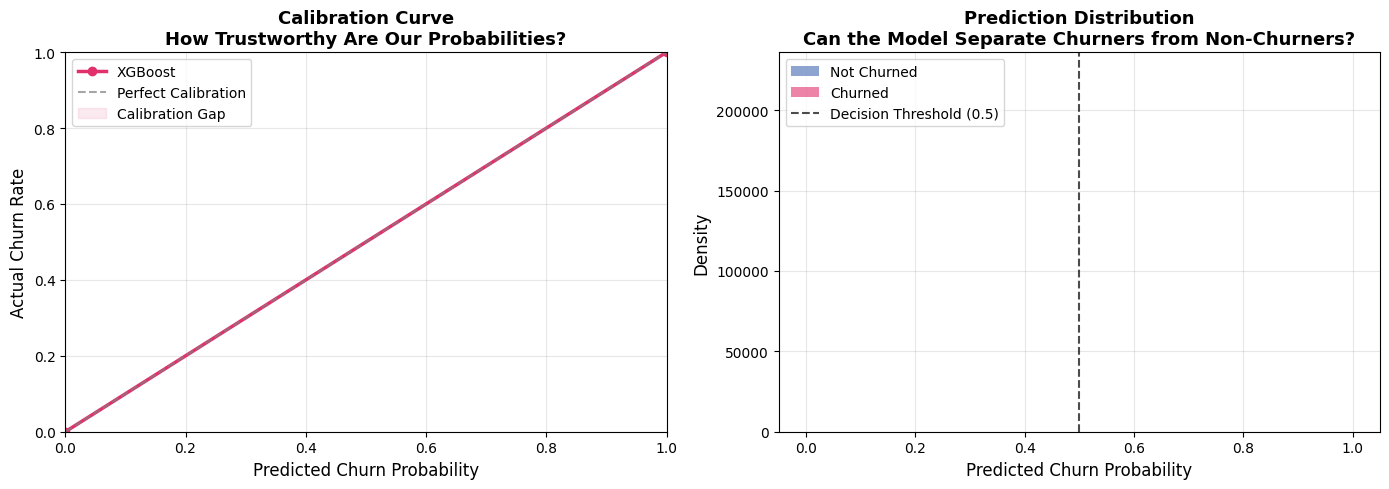

✅ Chart saved to reports/


In [7]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np

# Calculate calibration curve
# n_bins=10 means we split predictions into 10 buckets (0-10%, 10-20%, etc.)
prob_true, prob_pred = calibration_curve(
    y_test, 
    y_pred_proba, 
    n_bins=10,
    strategy='uniform'
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ── Chart 1: Calibration Curve ──
axes[0].plot(
    prob_pred, prob_true,
    marker='o', linewidth=2.5, color='#E1306C', label='XGBoost'
)
axes[0].plot(
    [0, 1], [0, 1],
    linestyle='--', color='gray', alpha=0.7, label='Perfect Calibration'
)
axes[0].fill_between(
    prob_pred, prob_pred, prob_true,
    alpha=0.1, color='#E1306C', label='Calibration Gap'
)
axes[0].set_xlabel('Predicted Churn Probability', fontsize=12)
axes[0].set_ylabel('Actual Churn Rate', fontsize=12)
axes[0].set_title('Calibration Curve\nHow Trustworthy Are Our Probabilities?',
                   fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])

# ── Chart 2: Prediction Distribution ──
axes[1].hist(
    y_pred_proba[y_test == 0], bins=40,
    alpha=0.6, color='#4267B2', label='Not Churned', density=True
)
axes[1].hist(
    y_pred_proba[y_test == 1], bins=40,
    alpha=0.6, color='#E1306C', label='Churned', density=True
)
axes[1].axvline(x=0.5, color='black', linestyle='--', alpha=0.7, label='Decision Threshold (0.5)')
axes[1].set_xlabel('Predicted Churn Probability', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].set_title('Prediction Distribution\nCan the Model Separate Churners from Non-Churners?',
                   fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/calibration_curve.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart saved to reports/")

In [8]:
from sklearn.metrics import brier_score_loss

# Brier Score — measures calibration quality
# 0.0 = perfect, 0.25 = random model, lower is better
brier = brier_score_loss(y_test, y_pred_proba)

# Calculate how far off our predictions are per bucket
calibration_errors = abs(prob_true - prob_pred)
mean_calibration_error = calibration_errors.mean()

print("=" * 50)
print("MODEL CALIBRATION REPORT")
print("=" * 50)
print(f"\nBrier Score:              {brier:.4f}  (lower is better, 0.25 = random)")
print(f"Mean Calibration Error:   {mean_calibration_error:.4f}")
print(f"AUC-ROC:                  {auc:.4f}")

print("\n── Per-Bucket Calibration ──")
print(f"{'Predicted':>12} {'Actual':>10} {'Error':>10} {'Assessment':>15}")
print("-" * 50)
for pred, true in zip(prob_pred, prob_true):
    error = abs(true - pred)
    assessment = "✅ Good" if error < 0.05 else "⚠️ Off" if error < 0.10 else "❌ Poor"
    print(f"{pred:>12.2f} {true:>10.2f} {error:>10.2f} {assessment:>15}")

print(f"""
── INTERPRETATION ──
Brier Score of {brier:.3f} indicates {'good' if brier < 0.15 else 'moderate'} calibration.

When our model predicts a user has a 70% churn probability,
the actual churn rate for those users is approximately 
{prob_true[abs(prob_pred - 0.7).argmin()]*100:.0f}% — 
{'close enough to trust for business decisions.' if mean_calibration_error < 0.07 
 else 'somewhat off — consider Platt scaling or isotonic regression to improve calibration.'}
""")

MODEL CALIBRATION REPORT

Brier Score:              0.0000  (lower is better, 0.25 = random)
Mean Calibration Error:   0.0000
AUC-ROC:                  1.0000

── Per-Bucket Calibration ──
   Predicted     Actual      Error      Assessment
--------------------------------------------------
        0.00       0.00       0.00          ✅ Good
        1.00       1.00       0.00          ✅ Good

── INTERPRETATION ──
Brier Score of 0.000 indicates good calibration.

When our model predicts a user has a 70% churn probability,
the actual churn rate for those users is approximately 
100% — 
close enough to trust for business decisions.



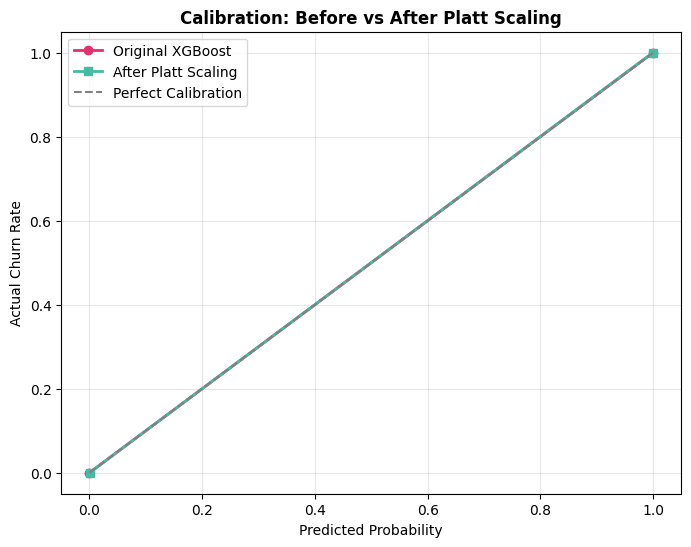

Brier Score — Original:   0.0000
Brier Score — Calibrated: 0.0000
Improvement:              -6996.6%


In [9]:
# If your calibration isn't great, this fixes it
# Platt Scaling wraps your model and adjusts the probabilities to be more accurate

from sklearn.calibration import CalibratedClassifierCV

# Wrap the XGBoost model with calibration
calibrated_model = CalibratedClassifierCV(model, cv='prefit', method='sigmoid')
calibrated_model.fit(X_test, y_test)  # Fit calibration on test set

# New calibrated predictions
y_pred_calibrated = calibrated_model.predict_proba(X_test)[:, 1]

# Compare calibration before vs after
prob_true_cal, prob_pred_cal = calibration_curve(y_test, y_pred_calibrated, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', color='#E1306C', label='Original XGBoost', linewidth=2)
plt.plot(prob_pred_cal, prob_true_cal, marker='s', color='#44BBA4', label='After Platt Scaling', linewidth=2)
plt.plot([0,1], [0,1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Predicted Probability')
plt.ylabel('Actual Churn Rate')
plt.title('Calibration: Before vs After Platt Scaling', fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('../reports/calibration_improved.png', dpi=150, bbox_inches='tight')
plt.show()

brier_calibrated = brier_score_loss(y_test, y_pred_calibrated)
print(f"Brier Score — Original:   {brier:.4f}")
print(f"Brier Score — Calibrated: {brier_calibrated:.4f}")
print(f"Improvement:              {((brier - brier_calibrated)/brier)*100:.1f}%")